# Record Demo

This notebook is used for recording expert demos for imitation learning as well as finding the hit judgement areas for simulated game environment purposes

In [1]:
import os
import warnings
import logging
import time
import mss
import torch
import numpy as np
from pynput import keyboard
from pynput.keyboard import Controller, Key
from concurrent.futures import ThreadPoolExecutor
import pathlib
from helper import SocketListener, preprocess_actions, detect, capture, pad_inner_array, DataQueue
from reward import Reward
import matplotlib.pyplot as plt

if not os.path.exists('yolov5'):
    !git clone https://github.com/ultralytics/yolov5
    !pip install -r yolov5/requirements.txt

warnings.simplefilter("ignore", FutureWarning)
logging.getLogger('ultralytics').setLevel(logging.ERROR)

executor = ThreadPoolExecutor(max_workers=8)

In [2]:
pathlib.PosixPath = pathlib.WindowsPath # https://github.com/ultralytics/yolov5/issues/10240#issuecomment-1662573188
model = torch.hub.load('ultralytics/yolov5', 'custom', path='./models/best.pt', force_reload=True)  

monitor = mss.mss().monitors[2]
t, l, w, h = monitor['top'], monitor['left'], monitor['width'], monitor['height']
region = {'left': l+int(w * 0.338), 'top': t, 'width': w-int(w * 0.673), 'height': h} 

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to C:\Users\tiany/.cache\torch\hub\master.zip
YOLOv5  2024-12-2 Python-3.10.6 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)

Fusing layers... 
Model summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


In [3]:
# Store pressed keys
pressed_keys = set()

def on_press(key):
    try:
        pressed_keys.add(key.char)  # Record alphanumeric keys
    except AttributeError:
        pressed_keys.add(str(key))  # Record special keys

def on_release(key):
    try:
        pressed_keys.discard(key.char)  # Remove released alphanumeric keys
    except AttributeError:
        pressed_keys.discard(str(key))  # Remove released special keys

def record_key():
    # Record the current frame's keys
    current_keys = list(pressed_keys) 
    return current_keys

key_listener = keyboard.Listener(on_press=on_press, on_release=on_release)
key_listener.start()
keyboard_controller = Controller()
key_press = ['s', 'd', 'k', 'l']


def press_key(keys_to_press, note_type):
  for i in range(len(keys_to_press)):
    if note_type[i] in [2, 3]:
      keyboard_controller.press(keys_to_press[i])
      
  time.sleep(0.04)
  
  for i in range(len(keys_to_press)):
    if note_type[i] in [2, 1]:
      keyboard_controller.release(keys_to_press[i])

In [4]:
# Capture keyboard input at n FPS
FPS = 15
frame_duration = 1 / FPS

# Track notes and key input
frames = []
actions = []
hit_results = []

In [5]:
data_queue = DataQueue()
listener = SocketListener()
listener.start(data_handler=data_queue.add, traceback=True)

Listening on 127.0.0.1:5555


In [6]:
auto_play = False
song_begin = False
total_reward = 0

while listener.is_first_connection or listener.is_listening:
  if listener.has_connection:
    song_begin = True
    time_start = time.time()
    
    keys_thread = executor.submit(record_key)
    action_queue = keys_thread.result()
    
    image = capture(region)
    vision_thread = executor.submit(detect, np.array(image), model)
    notes = vision_thread.result() 
    
    if auto_play:  
      action_queue = []
      note_type = []
      for note in notes:
        class_id, lane, y_center = note
        lane -= 1
        
        if y_center > 810 and class_id == 1:
          action_queue.append(key_press[lane])
          note_type.append(class_id)
        elif y_center > 865:
          action_queue.append(key_press[lane])
          note_type.append(class_id)
      
      actions.append((action_queue, note_type))
    else:
      actions.append(action_queue)
    
    frames.append(notes)
    data = data_queue.get()
    hit_results.append(data)

    if len(action_queue) > 0 and auto_play:
      executor.submit(press_key, action_queue, note_type)
    
    data_queue.clear()
    
    if not auto_play:
      elapsed_time = time.time() - time_start
      if elapsed_time < frame_duration:
          time.sleep(frame_duration-elapsed_time)
            
  elif song_begin:
    listener.stop()
    break

Connection closed.


In [7]:
print(len(frames), len(actions), len(hit_results))
print(total_reward)

1504 1504 1504
0


In [8]:
def preprocess_auto_actions(actions):
  parsed_actions = []
  keys_held = [False] * 4
  key_mapping = {'s': 0, 'd': 1, 'k': 2, 'l': 3}

  for keys, note_type in actions:
    action = [0] * 4

    for i in range(len(keys)):
      key_index = key_mapping[keys[i]]
      
      # When key is hold
      if note_type[i] == 3:
        action[key_index] = 3
        keys_held[key_index] = True
      else: # When key is released or pressed
        action[key_index] = note_type[i]
        keys_held[key_index] = False
    
    # Continuously parse held keys as holds
    for i in range(4):
      if keys_held[i]:
        action[i] = 3
        
    parsed_actions.append(action)

  return parsed_actions

In [9]:
frames = frames[:len(hit_results)]
if auto_play:
  keys = preprocess_auto_actions(actions)
else:
  keys = preprocess_actions(actions)
# actions = actions[:len(hit_type)]

In [10]:
padded_hit_type = pad_inner_array(hit_results, pad_value=-1, pad_len=4)
padded_frames = pad_inner_array(frames, pad_value=[0, 0, 0], pad_len=20)
t_hit_type = torch.tensor(padded_hit_type)
t_frames = torch.tensor(padded_frames)

Removed 13 outliers
[9, 9, 49, 165, 495, 627]
Average Miss: 831.5555555555555
Average Meh: 818.6666666666666
Average Ok: 864.2708333333334
Average Good: 837.7333333333333
Average Great: 833.8226600985222
Average Perfect: 843.062893081761


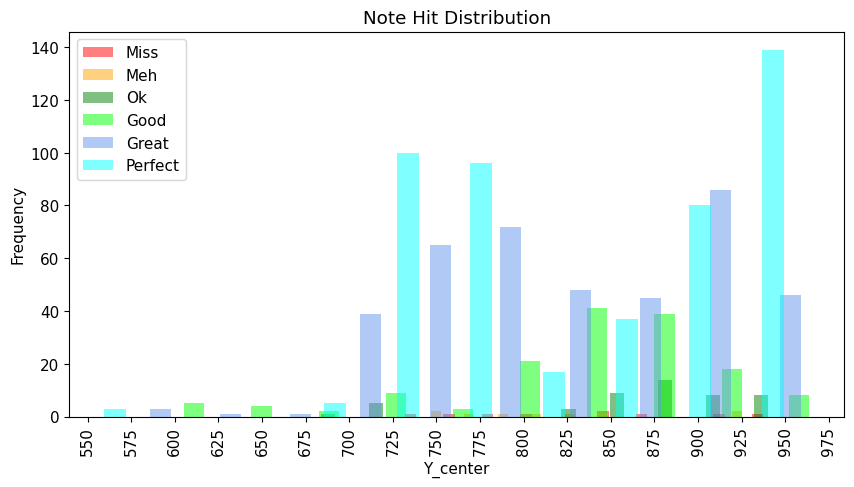

In [11]:
# Hit type name and plot color
hit_type_dict = {
  0 : ('Miss', 'red'),
  1 : ('Meh', 'orange'),
  2 : ('Ok', 'green'),
  3 : ('Good', 'lime'),
  4 : ('Great', 'cornflowerblue'),
  5 : ('Perfect', 'aqua'),
}

hit_type_locs = [0] * 6 # The y_center of each hit type
hit_res = [0] * 6 # The count of each hit type
combined = [] # Combined frames, keys, and hit types

for i in range(len(frames)):  
  # Sum of hit type will be greater than -4 if there is a valid hit type in this frame
  if sum(t_hit_type[i]) > -4:
    for h in t_hit_type[i]:
      if h not in [-1, 6, 7]: # Exclude pad values and flags
        hit_res[h] += 1
    
    combined.append((t_frames[i][0], keys[i], t_hit_type[i]))

combined = np.array(combined)
outlier_thresh = 3
remove_count = 0

for hit_type_id in range(6):
  # Filter by hit types
  filter = [x for x in combined if hit_type_id in x[2]]
  hit_type_points = []
  
  if len(filter) == 0:
    continue
  
  for f in filter:
    point = f[0][2]
    hit_type_points.append(point.item())
  
  # Remove any potential outliers
  std = np.std(hit_type_points)
  mean = np.mean(hit_type_points)
  for x in hit_type_points:
    if std == 0:
      continue
    
    z = abs(x - mean)/std
    if z > outlier_thresh:
      remove_count += 1
      hit_type_points.remove(x)
  
  hit_type_locs[hit_type_id] = hit_type_points
  
print(f'Removed {remove_count} outliers')
print(hit_res)

%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 5))
plt.title('Note Hit Distribution')
plt.xlabel('Y_center')
plt.ylabel('Frequency')
plt.xticks(np.arange(0, 1000, 25), rotation=90)

for i in range(len(hit_type_locs)):
  hit_type, color = hit_type_dict[i]
  print(f'Average {hit_type}: {np.mean(hit_type_locs[i])}')
  ax.hist(hit_type_locs[i], label=hit_type, linestyle='None', color=color, rwidth=0.3, alpha=0.5)
  
ax.legend()
plt.show()

In [12]:
print(keys)

[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0

In [13]:
def save_data(name):
    os.makedirs('./expert_demo/', exist_ok=True)

    data = {"frame": frames,
            "action": keys,
            "hit_type": hit_results}
    
    torch.save(data, f"./expert_demo/{name}_{time.time()}.pth")

In [14]:
save_data("replay")

In [15]:
#test in game
# song_begin = False
# while listener.is_listening or listener.is_first_connection:
#     if listener.has_connection:
#         song_begin = True
#         time_start = time.time()
#         vision_thread = executor.submit(capture, region)
#         image = vision_thread.result()

#         vision_thread = executor.submit(detect, np.array(image), model)
#         notes = vision_thread.result() 
        
#         perform_action(actions[i])

#         elapsed_time = time.time() - time_start
#         if elapsed_time < frame_duration:
#                 time.sleep(frame_duration-elapsed_time)

#     elif song_begin:
#          break